# Optimizers

Notebook created in PyTorch by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2020).

Updated by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/).

In this lab we will do a deep dive on how to use an optimizer to minimize an arbitrary function, as well as best practices on how to use the optimizers for Deep Learning.

In [1]:
import torch
import torch.optim as optim
import plotly.graph_objects as go
import time
import numpy as np

We can use the following functions to view an animation of how the optimizer finds the minimum of a function. These functions use [plotly](https://plotly.com/) to do the plots, which is a great choice thanks to its options to create animations.

In [2]:
def animate_2d_optimization(f, x_range, points):

    x = torch.linspace(*x_range, steps=1000)
    function_graph = go.Scatter(x=x, y=f(x), mode='lines', name="Function")

    def frame_data(p):
        return [function_graph,
                go.Scatter(x=[p], y=[f(torch.tensor([float(p)])).item()], mode='markers', marker=dict(size=[15]), name="Point")]

    frames = [go.Frame(data=frame_data(p)) for p in points]

    fig = go.Figure(
        data=frame_data(points[0]),
        layout=go.Layout(
            title="Start optimization",
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label="Play",
                            method="animate",
                            args=[None])])],
            showlegend=False
        ),
        frames=frames,
    )
    return fig


def animate_3d_optimization(f, x_range, y_range, points):

    x = torch.linspace(*x_range, steps=100)
    y = torch.linspace(*x_range, steps=100)
    x, y = torch.meshgrid([x, y])
    function_surface = go.Surface(x=x, y=y, z=f(x, y), name="Function")

    def frame_data(p):
        return [function_surface,
                go.Scatter3d(x=[p[0]], y=[p[1]], z=[0.05+f(torch.tensor([p[0]], dtype=float), torch.tensor([p[1]], dtype=float)).item()], mode='markers', marker=dict(size=[15], color="white"), name="Point")]

    frames = [go.Frame(data=frame_data(p)) for p in points]

    fig = go.Figure(
        data=frame_data(points[0]),
        layout=go.Layout(
            title="Start optimization",
            showlegend=False,
            updatemenus=[dict(
                            type="buttons",
                            buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None])
                            ])]
        ),
        frames=frames,
    )
    return fig

## Optimization of single-input functions
Let's start by finding the optimum of a very simple single-parameter function.

In [3]:
def f(x):
    return torch.tanh(x-2.5)**2 + 0.3*torch.tanh(x)**2

### Exercise 1

Many people say that the learning rate is the most important hyperparameter when doing Deep Learning. We will see now the important of a good choice of LR.

Complete the `optimize_1d_function` and call it with an `init_value` of 4.5. Use SGD as an optimizer, and optimize the tensor `v`.

In [4]:
def optimize_1d_function(f, init_value, lr=0.1, steps=60):
    points = []
    v = torch.tensor([float(init_value)], requires_grad=True)

    # TODO: Use SGD as an optimizer
    optimizer = torch.optim.SGD([v], lr)

    for step in range(steps):
        points.append(v.item())

        # TODO
        optimizer.zero_grad()

        loss = f(v)

        # TODO
        loss.backward()

        # TODO
        optimizer.step()

    return animate_2d_optimization(f, x_range=[-10, 10], points=points)

In [5]:
optimize_1d_function(f, 4.5)

Output hidden; open in https://colab.research.google.com to view.

Is the optimizer learning fast enough? We have to tune the hyperparameters. Let's try using a LR of 10.

In [6]:
optimize_1d_function(f, 4.5, lr=10)

Output hidden; open in https://colab.research.google.com to view.

Clearly, this LR was too large. Let's try now a LR of 1.

In [7]:
optimize_1d_function(f, 4.5, lr=1)

Output hidden; open in https://colab.research.google.com to view.

Great! This was the correct choice. Note that we tried 1e-1, 1e1 and 1e2, and only 1e1 worked. This is a toy example, but this exact fenomenon happens when choosing a LR to optimize our Deep Learning model. Luckily, we have more advanced optimizers that make this choice easier!

**Extra:** Could we have used `init_value` = 0? Why?

### Exercise 2

Complete the function again, but now use Adam instead of SGD. Then, we will try it with the same `init_value` (4.5) and a lr=0.1 and lr=1.

In [8]:
def optimize_1d_function_adam(f, init_value, lr=0.1, steps=60):
    points = []
    v = torch.tensor([float(init_value)], requires_grad=True)

    # TODO: Use Adam instead of SGD
    optimizer = torch.optim.Adam([v], lr)

    for step in range(steps):
        optimizer.zero_grad()
        points.append(v.item())
        loss = f(v)
        loss.backward()
        optimizer.step()

    return animate_2d_optimization(f, x_range=[-10, 10], points=points)

In [9]:
optimize_1d_function_adam(f, 4.5, lr=0.1)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
optimize_1d_function_adam(f, 4.5, lr=1)

Output hidden; open in https://colab.research.google.com to view.

We can see that both learning rates worked! But neither of them worked as well as SGD with lr=1. This is the advantage of ADAM, the choice of the learning rate is much more lenient. The exact same thing passes when training neural networks.

**Key takeaways**

* SGD works great, but requires tunning the lr much more. We had to use specifically 1e1, otherwise the optimizer didn't find the optimum. This makes SGD the correct choice when we are willing to try many different learning rates and want the most optimal neural network possible.

* Adam is much more lenient than SGD. Any value between 1e-1 and 1e1 works, and gets to an optimum almost as good as SGD. This makes Adam the default choice for most people, since it performs almost as well as SGD but doesn't require nearly as much tunning.

## Optimization of multi-input functions

Now, we will work on a more realistic case. The function we will try to optimize will have 2 parameters. The main difference between 1d and 2d is that we now can have saddle points, which are points that are a maximum in a direction and a minimum in another direction.

In [11]:
def f(x, y):
    return 1e-1*((x)**2 - (y)**2)

In [12]:
def optimize_2d_function(f, init_value, lr=0.1, steps=20):
    points = []
    v = torch.tensor(init_value, requires_grad=True)
    optimizer = optim.SGD([v], lr)

    for step in range(steps):
        points.append(v.detach().numpy().copy().tolist())
        optimizer.zero_grad()
        loss = f(v[0], v[1])
        loss.backward()
        optimizer.step()

    return animate_3d_optimization(f, x_range=[-10, 10], y_range=[-10, 10], points=points)

### Exercise 3

Search in a logarithmic scale (0.1, 1, 10, 100...) the minimum value for the learning rate necessary to escape from the saddle point, when starting at [-5, 0.01].

In [31]:
optimize_2d_function(f, [-5, 0.01], lr=1)

Output hidden; open in https://colab.research.google.com to view.

Did we have to use a large learning rate? Using a value that's too high can hinder the training process. Is there another way to escape from saddle points?

### Exercise 4

Now use SGD with 0.9 momentum. We will try a learning rate of 1 with the same starting point.

**Extra:** Do the same but with Nesterov accelerated momentum.

In [14]:
def optimize_2d_function_momentum(f, init_value, lr=0.1, steps=20):
    points = []
    v = torch.tensor(init_value, requires_grad=True)

    # TODO: Use SGD with 0.9 momentum
    optimizer = torch.optim.SGD([v], lr=lr, momentum=0.9)

    for step in range(steps):
        points.append(v.detach().numpy().copy().tolist())
        optimizer.zero_grad()
        loss = f(v[0], v[1])
        loss.backward()
        optimizer.step()

    return animate_3d_optimization(f, x_range=[-10, 10], y_range=[-10, 10], points=points)

In [15]:
optimize_2d_function_momentum(f, [-5, -0.01], lr=1)

Output hidden; open in https://colab.research.google.com to view.

By adding momentum, we were able to escape the saddle point with a lower learning rate. That's great!

**Key takeaway:** When using SGD, we almost always want to add momentum. It will generally accelerate learning without adding the problems of using a high learning rate. The only negative side is that this adds a new hyperparamter to tune (0.9 is a good reference value for momentum).

## How to find a good initial learning rate? The LR Range Test

In 2015, Leslie N. Smith more or less formalized the above trial-and-error into a technique called the LR Range Test. The idea is simple, you just run your model and data for a few iterations, with the learning rate initially start at a very small value and then increase after each iteration. You record the loss for each value of learning rate and plot it up.
![lr-test](https://miro.medium.com/max/1280/1*U0Y0HWHhFZu9mHyGf3OoRw.png)

We'll implement and try this method to find a good learning rate for training CIFAR10 with a resnet34 and Adam.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
device = torch.device("cuda")

In [17]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)
])
dataset = datasets.CIFAR10(root="data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)


100%|██████████| 170498071/170498071 [00:01<00:00, 86657731.06it/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [18]:
model = models.resnet34(num_classes=10).to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

We will search for the learning rate between 1e-9 and 1e2, using np.logspace.

In [20]:
lr_range = np.logspace(-9, 2, num=200)

### Exercise 5

Complete the code to do the test. You can modify the learning rate by modifying `optimizer.param_groups[0]["lr"] = ...`

In [21]:
loss_history = []

for lr, (images, targets) in zip(lr_range, dataloader):
    # TODO: Set the learning rate to lr
    optimizer.param_groups[0]["lr"] = lr

    # TODO
    optimizer.zero_grad()

    images, targets = images.to(device), targets.to(device)

    # TODO
    output = model(images)

    # TODO
    loss = criterion(output, targets)

    # TODO
    loss.backward()

    # TODO
    optimizer.step()

    loss_history.append(loss.item())

Now we can check what is the optimal Learning Rate in the plot. Even though it's noisy, we can see a good value for the learning rate. Can you spot it?

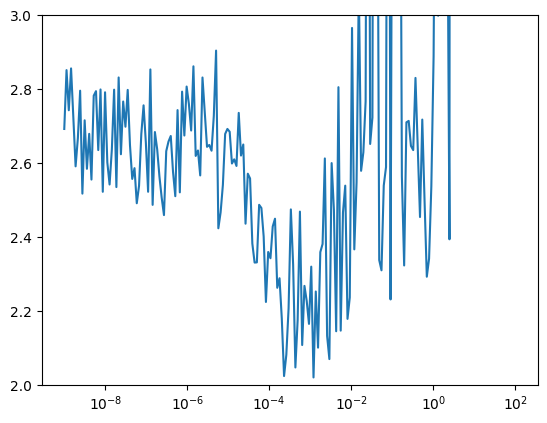

In [22]:
import matplotlib.pyplot as plt

plt.plot(lr_range, loss_history)
plt.ylim([2, 3])
plt.xscale("log")

## I've found a good initial learning rate. Now what? LR schedulers

A general good practice is to use a learning rate scheduler. One of the most useful ones is `ReduceLROnPlateau`. This scheduler decay the learning rate every time the loss function gets stuck. The use of an optimizer like this one can help squeeze a bit more performance of your model. We will see how to use it in PyTorch. We will train the same model as before, using a lr of 1e-3 (the largest acceptable value we found using the lr test).

In [23]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)
])
dataset = datasets.CIFAR10(root="data", download=True, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


First, let's get a baseline without an scheduler:

In [24]:
model = models.resnet34(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
epochs = 2
for epoch in range(epochs):
    losses = []
    for i, (images, targets) in enumerate(loader):
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        loss = criterion(output, targets)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        loss_history.append(loss.item())
        if i%50 == 0:
            print(f"Epoch {epoch} [{i}/{len(loader)}]: loss: {np.mean(losses):.2f}, lr={optimizer.param_groups[0]['lr']}")

Epoch 0 [0/782]: loss: 2.54, lr=0.001
Epoch 0 [50/782]: loss: 2.10, lr=0.001
Epoch 0 [100/782]: loss: 1.92, lr=0.001
Epoch 0 [150/782]: loss: 1.83, lr=0.001
Epoch 0 [200/782]: loss: 1.78, lr=0.001
Epoch 0 [250/782]: loss: 1.73, lr=0.001
Epoch 0 [300/782]: loss: 1.69, lr=0.001
Epoch 0 [350/782]: loss: 1.66, lr=0.001
Epoch 0 [400/782]: loss: 1.63, lr=0.001
Epoch 0 [450/782]: loss: 1.60, lr=0.001
Epoch 0 [500/782]: loss: 1.57, lr=0.001
Epoch 0 [550/782]: loss: 1.54, lr=0.001
Epoch 0 [600/782]: loss: 1.52, lr=0.001
Epoch 0 [650/782]: loss: 1.49, lr=0.001
Epoch 0 [700/782]: loss: 1.48, lr=0.001
Epoch 0 [750/782]: loss: 1.46, lr=0.001
Epoch 1 [0/782]: loss: 1.23, lr=0.001
Epoch 1 [50/782]: loss: 1.14, lr=0.001
Epoch 1 [100/782]: loss: 1.12, lr=0.001
Epoch 1 [150/782]: loss: 1.11, lr=0.001
Epoch 1 [200/782]: loss: 1.10, lr=0.001
Epoch 1 [250/782]: loss: 1.09, lr=0.001
Epoch 1 [300/782]: loss: 1.08, lr=0.001
Epoch 1 [350/782]: loss: 1.08, lr=0.001
Epoch 1 [400/782]: loss: 1.07, lr=0.001
Epoch 

### Exercise 6
Now we will use a scheduler. First, we have to declare it from the `torch.optim` module. They work very similar to optimizers.

In [26]:
model = models.resnet34(num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=150, factor=0.5)

Complete the training code with a scheduler. You should add the scheduler step after the optimizer step.

In [28]:
epochs = 2
for epoch in range(epochs):
    losses = []
    for i, (images, targets) in enumerate(loader):
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        loss = criterion(output, targets)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        # TODO
        scheduler.step(loss)

        loss_history.append(loss.item())
        if i%50 == 0:
            print(f"Epoch {epoch} [{i}/{len(loader)}]: loss: {np.mean(losses):.2f}, lr={optimizer.param_groups[0]['lr']}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



Epoch 0 [0/782]: loss: 2.55, lr=0.001
Epoch 0 [50/782]: loss: 2.07, lr=0.001
Epoch 0 [100/782]: loss: 1.92, lr=0.001
Epoch 0 [150/782]: loss: 1.84, lr=0.001
Epoch 0 [200/782]: loss: 1.78, lr=0.001
Epoch 0 [250/782]: loss: 1.73, lr=0.001
Epoch 0 [300/782]: loss: 1.69, lr=0.001
Epoch 0 [350/782]: loss: 1.65, lr=0.001
Epoch 0 [400/782]: loss: 1.61, lr=0.001
Epoch 0 [450/782]: loss: 1.59, lr=0.001
Epoch 0 [500/782]: loss: 1.56, lr=0.001
Epoch 0 [550/782]: loss: 1.53, lr=0.001
Epoch 0 [600/782]: loss: 1.52, lr=0.001
Epoch 0 [650/782]: loss: 1.49, lr=0.001
Epoch 0 [700/782]: loss: 1.47, lr=0.001
Epoch 0 [750/782]: loss: 1.45, lr=0.001
Epoch 1 [0/782]: loss: 1.28, lr=0.001
Epoch 1 [50/782]: loss: 1.11, lr=0.001
Epoch 1 [100/782]: loss: 1.09, lr=0.001
Epoch 1 [150/782]: loss: 1.07, lr=0.0005
Epoch 1 [200/782]: loss: 1.05, lr=0.0005
Epoch 1 [250/782]: loss: 1.04, lr=0.0005
Epoch 1 [300/782]: loss: 1.02, lr=0.0005
Epoch 1 [350/782]: loss: 1.01, lr=0.0005
Epoch 1 [400/782]: loss: 1.00, lr=0.0005
